In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [4]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd()))
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df

merged_data_summer = create_df('summer')

c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
c:\Users\Sevi\OneDrive - ETH Zurich\Master Energy Science and Technology\S2\Optimization in Energy Systems\Project\optimization_project\src\create_Dataframe.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


### Dishwasher

In [5]:
# Load data
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexible_demand = merged_data_summer['Inflexible_Demand_(kWh)'].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")

model.update()

Set parameter Username
Set parameter LicenseID to value 2654951
Academic license - for non-commercial use only - expires 2026-04-21


### Washing Machine

In [6]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts
for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0
        
model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")

model.update()

### Dryer 

In [7]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0

model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")

model.update()

### EV - G2V

In [8]:
# Include EV
# EV properties

min_power_ev = 1 #kW, minimum power to charge the EV
max_power_ev = 10 #kW, maximum power to charge the EV
kwh_per_km = 0.2  # kWh per km driven

max_capacity_ev = 70 #kWh

#Variables

#state of charge of the EV at each time step
soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")
#how much power is being charged at each time step
charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")
#binary variable to indicate if the EV is being charged at each time step
binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")


# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

# car can only charge if it is at home
model.addConstrs((binary_ev[t] <= merged_data_summer['ev_at_home_binary'][t] for t in range(len(binary_ev))), name="allowed_ev_summer")

# if car is at home, it can charge, but not more than the maximum power
# and if it is charging, it must be charging at least the minimum power
model.addConstrs((charging_ev[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage

initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")

model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - merged_data_summer['distance_driven'][t-1] * kwh_per_km for t in range(1,Time_interval)),name="ev_soc_update")

model.update()

### Objective Function and Optimization

In [9]:
# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * (merged_data_summer['Inflexible_Demand_(kWh)'][t] +
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + charging_ev[t]) for t in range(Time_interval)), GRB.MINIMIZE)

model.update()

# Optimize
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12811 rows, 7388 columns and 38964 nonzeros
Model fingerprint: 0xcb7ef533
Variable types: 1344 continuous, 6044 integer (6044 binary)
Coefficient statistics:
  Matrix range     [3e-01, 2e+01]
  Objective range  [2e-03, 7e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [1e+00, 6e+01]
Presolve removed 11664 rows and 6091 columns
Presolve time: 0.29s
Presolved: 1147 rows, 1297 columns, 11839 nonzeros
Variable types: 0 continuous, 1297 integer (1297 binary)
Found heuristic solution: objective 124.2308759

Root relaxation: objective 1.236991e+02, 346 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

### Print results

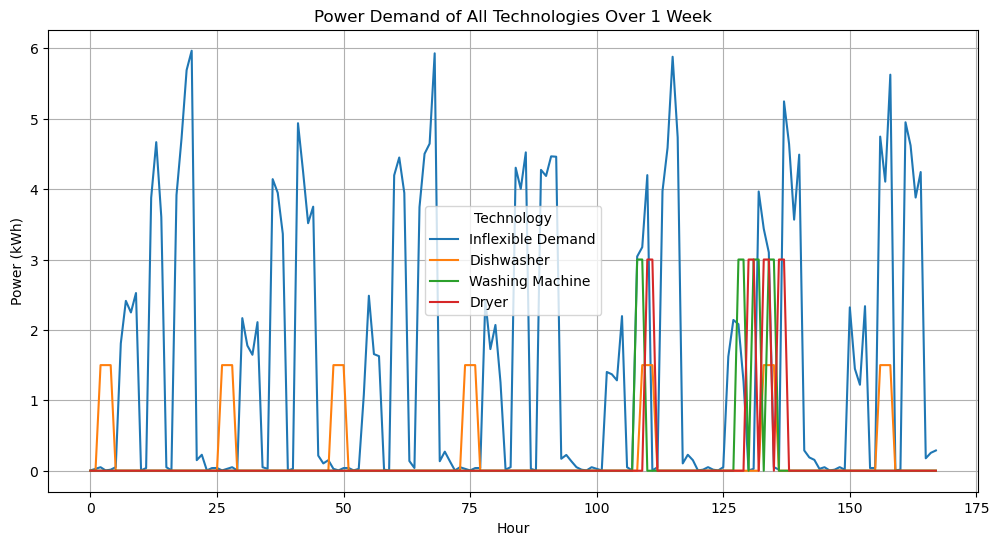

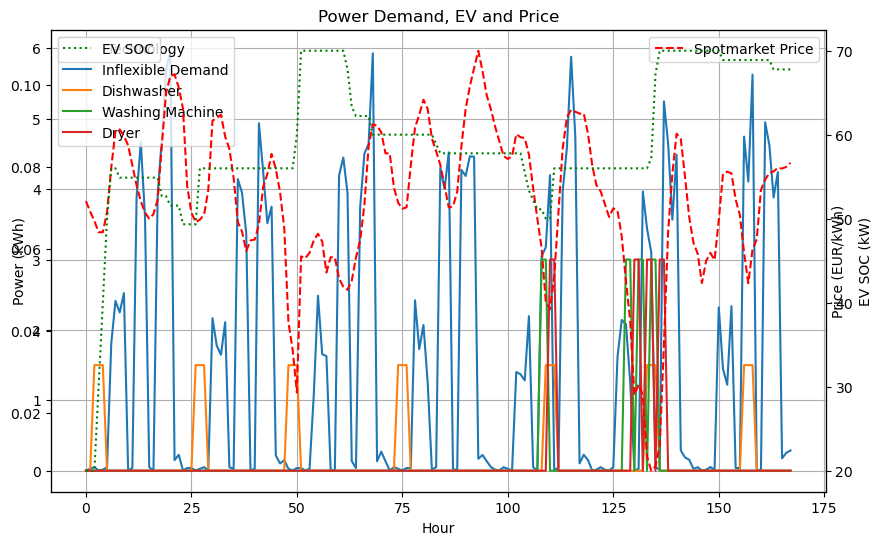

In [14]:
# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Inflexible Demand': merged_data_summer['Inflexible_Demand_(kWh)'][:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range],
    'Dryer': [power_dryer * binary_dryer[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Power demand of all technologies
plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Plot power demand (left y-axis)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology', ax=ax1)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power (kWh)')
ax1.legend(title='Technology', loc='upper left')
ax1.grid(True)

# Create a second y-axis for the price
ax2 = ax1.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'Price': merged_data_summer['Spotmarket_(EUR/kWh)'][:len(time_range)]}),
    x='Hour', y='Price', color='red', label='Spotmarket Price', linestyle='--', ax=ax2
)
ax2.set_ylabel('Price (EUR/kWh)')

ax3 = ax2.twinx()
sns.lineplot(
    data=pd.DataFrame({'Hour': list(time_range), 'EV SOC': [soc_ev[t].X for t in time_range]}),
    x='Hour', y='EV SOC', color='green', label='EV SOC', linestyle=':', ax=ax3
)
ax3.set_ylabel('EV SOC (kW)')

plt.title('Power Demand, EV and Price')
plt.show()